In [196]:
# Standard Python libraries
import os
import time
import warnings
from IPython.display import clear_output

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Qiskit Core
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.primitives import Sampler

# Qiskit Algorithms
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

# Qiskit Machine Learning
from qiskit_machine_learning.algorithms.classifiers import (
    NeuralNetworkClassifier,
    VQC
)
from qiskit_machine_learning.algorithms.regressors import (
    NeuralNetworkRegressor,
    VQR
)
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC

# Qiskit Runtime
from qiskit_ibm_runtime import Session, Options, QiskitRuntimeService

In [197]:
def setup_environment():
    """Set up the environment with necessary configurations."""
    warnings.filterwarnings("ignore")
    pd.set_option("display.max_rows", None)
    plt.style.use('ggplot')
    algorithm_globals.random_seed = 12345

In [198]:
def load_and_preprocess_data(file_path='datasets/heart.csv'):
    """Load and preprocess the heart disease dataset."""
    heart_df = pd.read_csv(file_path, delimiter=',')

    # Convert categorical columns to strings
    string_col = heart_df.select_dtypes(include="object").columns
    heart_df[string_col] = heart_df[string_col].astype("string")

    # Encode categorical columns
    label_encoders = {}
    for column in heart_df.columns:
        if heart_df[column].dtype == 'string':
            le = LabelEncoder()
            heart_df[column] = le.fit_transform(heart_df[column])
            label_encoders[column] = le

    return heart_df, label_encoders

In [199]:
def evaluate_classical_models(X, y, models, kf):
    """Evaluate classical machine learning models."""
    results = {}
    for model_name, model in models.items():
        fold_scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = roc_auc_score(y_val, y_pred)
            fold_scores.append(score)

        results[model_name] = np.mean(fold_scores)
        print(f"{model_name} - Average ROC AUC Score: {results[model_name]:.4f}")
        print("------------------------------------------------------------------------")

    return results

In [200]:
def evaluate_vqc_model(X, y, feature_map, ansatz, optimizer, sampler, kf):
    """Evaluate the Variational Quantum Classifier (VQC) model."""
    quantum_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        vqc = VQC(sampler=sampler, feature_map=feature_map,
                  ansatz=ansatz, optimizer=optimizer)

        vqc.fit(X_train, y_train)
        score = vqc.score(X_val, y_val)
        quantum_scores.append(score)
        print(f"Fold {fold + 1} - Quantum VQC Score: {score:.4f}")
        print("------------------------------------------------------------------------")

    return np.mean(quantum_scores)

In [201]:
def evaluate_real_quantum_vqc(X_train, y_train, X_val, y_val, feature_map,
                            ansatz, optimizer, service, backend):
    """Evaluate VQC model on real quantum hardware."""
    vqc = VQC(sampler=Sampler(), feature_map=feature_map,
              ansatz=ansatz, optimizer=optimizer)

    with Session(service=service, backend=backend):
        print("Training on real quantum hardware...")
        start_time = time.time()
        vqc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        test_score = vqc.score(X_val, y_val)
        print(f"Test Score: {test_score:.4f}")
        print("------------------------------------------------------------------------")

    return test_score

In [202]:
def evaluate_pegasos_model(X_train, y_train, X_val, y_val, feature_map, C=1000, tau=100):
    """Evaluate the PegasosQSVC model."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    pegasos_qsvc.fit(X_train, y_train)
    pegasos_score = pegasos_qsvc.score(X_val, y_val)
    print(f"PegasosQSVC classification test score: {pegasos_score:.4f}")
    print("------------------------------------------------------------------------")

    return pegasos_score

In [203]:
def evaluate_real_quantum_pegasos(X_train, y_train, X_val, y_val, feature_map,
                                service, backend, C=1000, tau=100):
    """Evaluate PegasosQSVC model on real quantum hardware."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    with Session(service=service, backend=backend):
        print("Training on real quantum hardware...")
        start_time = time.time()
        pegasos_qsvc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        pegasos_score = pegasos_qsvc.score(X_val, y_val)
        print(f"Test Score: {pegasos_score:.4f}")
        print("------------------------------------------------------------------------")

    return pegasos_score


In [204]:
def create_estimator_qnn(X):
    """Create and configure EstimatorQNN."""
    qc = QNNCircuit(num_qubits=X.shape[1])
    estimator_qnn = EstimatorQNN(circuit=qc)
    # Test forward pass
    estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))
    return estimator_qnn

def create_sampler_qnn(X):
    """Create and configure SamplerQNN with parity mapping."""
    qc = QNNCircuit(ansatz=RealAmplitudes(X.shape[1], reps=1))

    def parity(x):
        """Maps bitstrings to 0 or 1 based on number of 1s."""
        return "{:b}".format(x).count("1") % 2

    output_shape = 2  # corresponds to number of classes

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=output_shape,
    )
    return sampler_qnn

In [205]:
def create_callback_function():
    """Create callback function for visualization during training."""
    objective_func_vals = []

    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()

    return callback_graph, objective_func_vals

In [206]:
def train_estimator_classifier(X_train, y_train, X_val, y_val, max_iterations=60):
    """Train and evaluate EstimatorQNN classifier."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)
    score = estimator_classifier.score(X_val, y_val)

    return estimator_classifier, score, objective_func_vals

def train_sampler_classifier(X_train, y_train, X_val, y_val, max_iterations=30):
    """Train and evaluate SamplerQNN classifier."""
    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    sampler_classifier.fit(X_train, y_train)
    score = sampler_classifier.score(X_val, y_val)

    return sampler_classifier, score, objective_func_vals

In [207]:
def evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val):
    """Evaluate EstimatorQNN classifier."""

    # Train and evaluate EstimatorQNN
    print("Training EstimatorQNN classifier...")
    estimator_classifier, estimator_score, estimator_vals = train_estimator_classifier(X_train, y_train, X_val, y_val)
    print(f"EstimatorQNN Score: {estimator_score:.4f}")
    print("------------------------------------------------------------------------")

    return estimator_score

In [208]:
def evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val,):
    """Evaluate SamplerQNN classifier."""

    # Train and evaluate SamplerQNN
    print("\nTraining SamplerQNN classifier...")
    sampler_classifier, sampler_score, sampler_vals = train_sampler_classifier(X_train, y_train, X_val, y_val,)
    print(f"SamplerQNN Score: {sampler_score:.4f}")
    print("------------------------------------------------------------------------")

    return sampler_score

In [209]:
def evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Estimator QNN model on real quantum hardware."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)

    with Session(service=service, backend=backend):
        print("Training Estimator QNN on real quantum hardware...")
        start_time = time.time()
        estimator_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = estimator_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Estimator QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")

    return e_qnn_score


In [210]:
def evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Sampler QNN model on real quantum hardware."""
    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    with Session(service=service, backend=backend):
        print("Training Sampler QNN on real quantum hardware...")
        start_time = time.time()
        sampler_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = sampler_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Sampler QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")

    return e_qnn_score


In [211]:
def evaluate_models(X, y, num_features, cross_validation_folds=2):
    """Main function to evaluate all models."""
    # Define classical models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Naive Bayes": GaussianNB(),
        "SVM (Linear Kernel)": SVC(kernel="linear"),
        "SVM (RBF Kernel)": SVC(kernel="rbf"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=32),
    }

    # Setup cross-validation
    kf = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)
    results = {}

    # Evaluate classical models
    results.update(evaluate_classical_models(X, y, models, kf))

    # Setup quantum parameters
    feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
    ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)
    optimizer = COBYLA(maxiter=100)
    sampler = Sampler()

    # Evaluate VQC model
    vqc_score = evaluate_vqc_model(X, y, feature_map, ansatz, optimizer, sampler, kf)
    results["Quantum VQC"] = vqc_score

    # Setup quantum service
    service = QiskitRuntimeService(instance="ibm-q/open/main")
    backend = service.least_busy(operational=True, min_num_qubits=5)

    # Get last split for real quantum evaluation
    train_idx, val_idx = list(kf.split(X, y))[-1]
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Evaluate on real quantum hardware
    results["Real Quantum VQC"] = evaluate_real_quantum_vqc(
        X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, service, backend)

    # Evaluate Pegasos models
    feature_map_peg = ZFeatureMap(feature_dimension=X.shape[1], reps=1)
    results["PegasosQSVC"] = evaluate_pegasos_model(
        X_train, y_train, X_val, y_val, feature_map_peg)
    results["Real Quantum PegasosQSVC"] = evaluate_real_quantum_pegasos(
        X_train, y_train, X_val, y_val, feature_map_peg, service, backend)
    
    # Evaluate QNN models
    results["Estimator QNN"] = evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val)
    results["Real Quantum Estimator QNN"] = evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val, service, backend)
    results["Sampler QNN"] = evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val)
    results["Real Quantum Sampler QNN"] = evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val, service, backend)

    return results

In [212]:
def main():
    """Main execution function."""
    setup_environment()
    heart_df, _ = load_and_preprocess_data()

    feature_counts = [2]
    all_results = {}

    for num_features in feature_counts:
        print(f"\nEvaluating models with {num_features} features...")

        # Select features based on correlation
        target = "HeartDisease"
        corr = heart_df.corr()[target].abs().sort_values(ascending=False)
        selected_features = corr.index[1:num_features + 1].tolist()

        # Prepare and normalize data
        X = heart_df[selected_features].values
        y = heart_df[target].values
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

        # Evaluate models
        results = evaluate_models(X, y, num_features)
        all_results[num_features] = results

    return all_results

if __name__ == "__main__":
    all_results = main()


Evaluating models with 2 features...
Logistic Regression - Average ROC AUC Score: 0.8096
------------------------------------------------------------------------
Naive Bayes - Average ROC AUC Score: 0.8096
------------------------------------------------------------------------
SVM (Linear Kernel) - Average ROC AUC Score: 0.8098
------------------------------------------------------------------------
SVM (RBF Kernel) - Average ROC AUC Score: 0.8064
------------------------------------------------------------------------
K-Nearest Neighbors - Average ROC AUC Score: 0.8096
------------------------------------------------------------------------
Fold 1 - Quantum VQC Score: 0.8170
------------------------------------------------------------------------
Fold 2 - Quantum VQC Score: 0.8017
------------------------------------------------------------------------
Training on real quantum hardware...
Training completed in 27.37 seconds.
Test Score: 0.8017
---------------------------------------

In [213]:
# Prepare data for visualization
model_names = list(all_results[2].keys())  # Get model names from the first result
feature_counts = list(all_results.keys())
scores = {model: [] for model in model_names}

for num_features in feature_counts:
    for model in model_names:
        scores[model].append(all_results[num_features].get(model, 0))

df_scores = pd.DataFrame(scores, index=feature_counts)
df_scores.index.name = "Number of Features"
df_scores.columns.name = "Model"

In [214]:
clean_styled = df_scores.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption('Model Performance Comparison')
display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8096,0.8096,0.8098,0.8064,0.8096,0.8094,0.8017,0.8148,0.6819,0.5098,0.5163,0.7712,0.7712


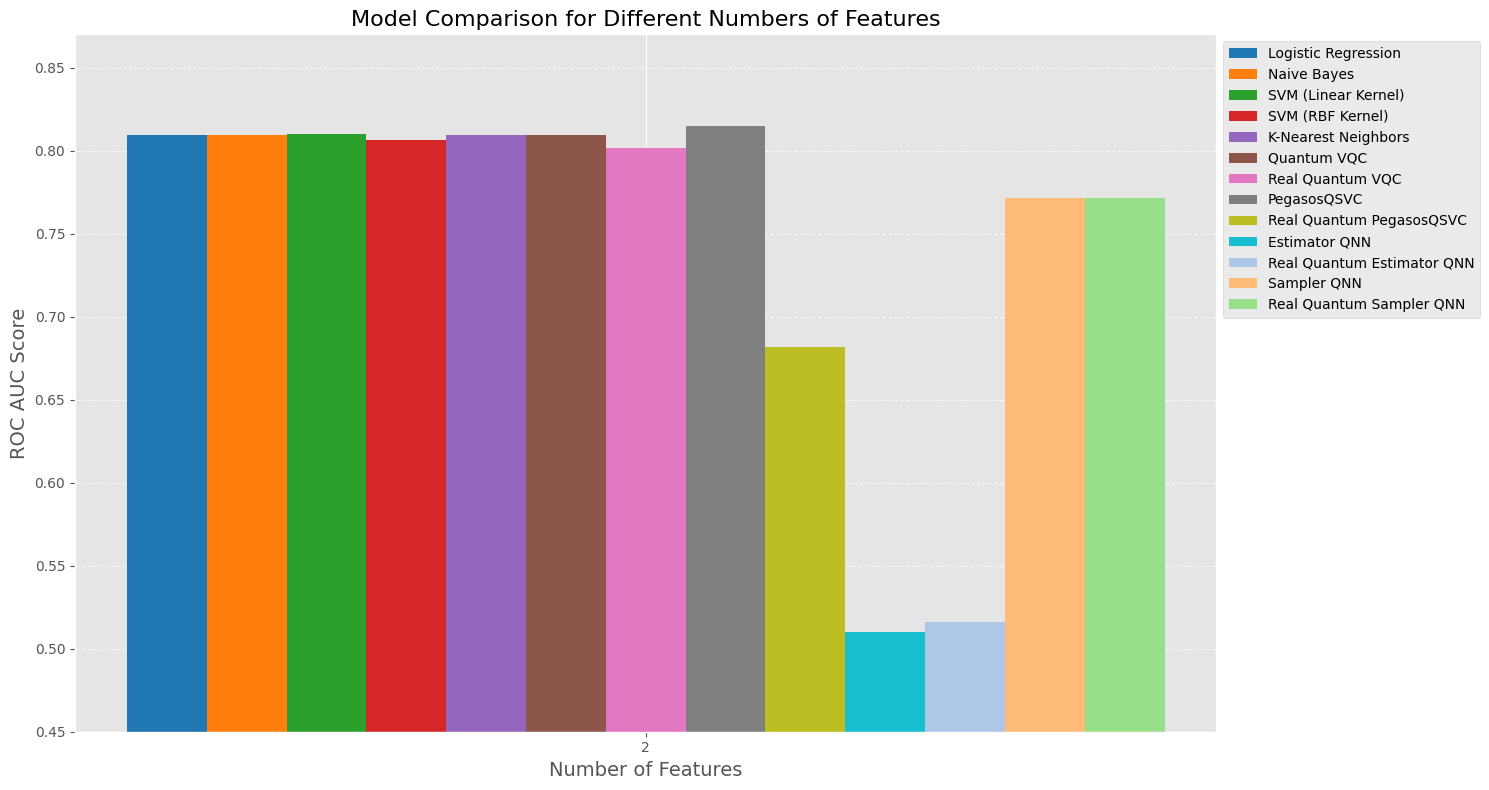

In [215]:


# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(15, 8))
bar_width = 0.10
for i, model in enumerate(model_names):
    scores = [all_results[n][model] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()